# New  Mexico Well History and Oil, Gas, Water Production Data Analysis

For this project, I’m using the latest version of well and production data collected by the [Oil Conservation Division](http://www.emnrd.state.nm.us/OCD/statistics.html), which regulates oil, gas, and geothermal activity in New Mexico. This dataset is public and free to download. (ftp://164.64.106.6/Public/OCD/OCD%20Interface%20v1.1/)

The project will focus on analyzing the influence of injection volume, well completion and production method on production volume, in the entire state and some individual formations.

In [1]:
# import libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Data Import

5 tables are chosen and read as pandas dataframe for this project:
+ *pool*: containing information on producing formation or subdivision of producing formation
+ *wchistory*: well completion history
+ *wellhistory*: well history 
+ *wcinjection*: well injection data
+ *wcproduction*: well production data

*note: the volume data are read separately due to large date size, which is flexable of futher data wrangling.*

In [2]:
# read the core data to pandas dataframe
pool = pd.read_csv('core/pool.csv')
wchistory = pd.read_csv('core/wchistory.csv')
wellhistory = pd.read_csv('core/wellhistory.csv')

C:\Users\Jing\Anaconda3\envs\ipykernel_py3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# read the volume data to pandas datafram
wcinjection = pd.read_csv('volumes/wcinjection.csv')

In [4]:
# read the volume data to pandas datafram
wcproduction = pd.read_csv('volumes/wcproduction.csv')

## Data Wrangling

In this section, I combine related columns into one column, reduce the size of big tables by only keeping useful columns for further analysis, remove trailing spaces, replace missing values as numpy NaNs, and fill the NaNs.
* *pool*: 
    - clear the trailing spaces in pool name column *pool_nam*,
    - cut down the table wchistory size by only keeping the columns useful in further analysis:
        + *pool_idn* - producing formation or subdivision of producing formation as defined by Order Hearing Order
        + *pool_nam* - name assigned to pool when pool is created by an R-Order
        + *pool_typ_cde* - pool type, as determined by the type of fluids in the pool
            - 1:	Gas (Prorated)
            - 2:	Gas (Non-prorated)
            - 3:	Oil
            - 4:	Associated
            - 5:	Salt Water Disposal
* *wchistory*: 
    - replace missing values with numpy NaNs, 
    - combine three columns (*api_st_cde, api_cnty_cde, api_well_idn*) to be one column *api* to identify wells, 
    - cut down the table wchistory size by only keeping the columns useful in further analysis:
        + *api* - well identify number
        + *pool_idn* - producing formation or subdivision of producing formation identifier
        + *eff_dte* - the date which the record is effective
        + *rec_termn_dte* - date record no longer effective 
        + *wc_stat_cde* - status of well completion
            - A:	Active
            - C:	Cancelled
            - D:	Dry Hole
            - N:	New, Not Drilled
            - X:	Never Drilled
            - T:	Temporary Abandonment
            - P:	Zone Permanently Plugged
            - Z:	Zones Temporarily Plugged
        + *well_typ_cde* - well type code
            - C:	CO2
            - G:	Gas
            - I:	Injection
            - M:	Miscellaneous
            - O:	Oil
            - S:	Salt Water Disposal
            - W:	Water
        + *prodn_meth_cde* - producing method code
            - P: Pumping
            - F: Flowing
            - G: Gas Lift
    - fill the NaNs in  column *prodn_meth_cde* from the value of the same well (same *api*),
    - change production method 'D' and 'I' to 'F' (flowing) according to search on website (https://wwwapps.emnrd.state.nm.us/ocd/ocdpermitting/Data/Wells.aspx), since the data dictionary doesn't explain the codes.
* *wellhistory*:
    - replace the missing values with numpy NaNs,
    - combine three columns (*api_st_cde, api_cnty_cde, api_well_idn*) to be one column *api* to identify wells, 
    - fill the NaNs in  column *directional_status* from the value of the same well (same *api*),
    - cut down the table wchistory size by only keeping the columns useful in further analysis:
        + *api* - well identify number
        + *directional_status* - differentiate vertical, horizontal, directional
* *wcinjection*:
    - remove the trailing spaces in *inj_knd_cde* column of table wcinjection, 
    - replace missing values with NaNs,
    - combine three columns (*api_st_cde, api_cnty_cde, api_well_idn*) to be one column *api* to identify wells, 
    - delete the three columns to cut down table size, and the useful columns: 
        + *api* - well identify number
        + *pool_idn* - identifier code for specific pool
        + *prodn_mth* - month in which injection occurred
        + *prodn_yr* - year that injection occurred
        + *inj_knd_cde* - product kind code
            - W:	Water
            - G:	Gas
            - C:	CO2
            - O:	Other
* *wcproduction*:
    - cut down the table wchistory size by only keeping the columns useful in further analysis,
    - combine three columns (*api_st_cde, api_cnty_cde, api_well_idn*) to be one column *api* to identify wells, 
    - further cut down the table wchistory size by deleting the three columns:
        + *api* - well identify number
        + *pool_idn* - identifier code for specific pool
        + *prodn_mth* - month in which production occurred
        + *prodn_yr* - year that production occurred
        + *prd_knd_cde* - product kind code
            - O:	Oil
            - G:	Gas
            - W:	Water
        + *prod_amt* - volume of fluid produced (MCF or BBLS)
    - remove the trailing spaces in *prd_knd_cde* column








table *pool*

In [5]:
# remove the trailing spaces in pool_nam column of table pool
pool.pool_nam = pool.pool_nam.str.replace(' ', '')
# cut down the table wchistory size by only keeping the columns useful in further analysis
pool = pool.loc[:,['pool_idn', 'pool_nam', 'pool_typ_cde']]

table *wchistory*

In [6]:
# replace the missing values with numpy NaN in table wchistory
wchistory = wchistory.replace(r'^\s+',np.nan, regex=True)

In [7]:
# combine three related columns (api_st_cde, api_cnty_cde, api_well_idn) as one (api) to identify wells in table wchistory
wchistory['api'] = wchistory.api_st_cde.apply(str) + wchistory.api_cnty_cde.apply(str) + wchistory.api_well_idn.apply(str)

In [8]:
# cut down the table wchistory size by only keeping the columns useful in further analysis
wchistory = wchistory.loc[:,['api', 'pool_idn', 'eff_dte', 'rec_termn_dte', 'wc_stat_cde', 'well_typ_cde', 'prodn_meth_cde']]
# fill the NaN values in column prodn_meth_cde
wchistory.prodn_meth_cde = wchistory.groupby('api')['prodn_meth_cde'].ffill()
wchistory.prodn_meth_cde = wchistory.groupby('api')['prodn_meth_cde'].bfill()
wchistory.loc[wchistory.wc_stat_cde != 'A'].prodn_meth_cde = np.nan

C:\Users\Jing\Anaconda3\envs\ipykernel_py3\lib\site-packages\pandas\core\generic.py:5086: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [9]:
# change production method 'D' and 'I' to 'F' (flowing) according to search on 
# https://wwwapps.emnrd.state.nm.us/ocd/ocdpermitting/Data/Wells.aspx
wchistory.prodn_meth_cde = wchistory.prodn_meth_cde.str.replace('D','F')
wchistory.prodn_meth_cde = wchistory.prodn_meth_cde.str.replace('I','F')

table *wellhistory*

In [10]:
# replace the missing values with numpy NaN in table wellhistory
wellhistory = wellhistory.replace(r'^\s+',np.nan, regex=True)
wellhistory = wellhistory.replace('',np.nan, regex=True)

In [11]:
# combine three related columns (api_st_cde, api_cnty_cde, api_well_idn) as one (api) to identify wells in table wellhistory
wellhistory['api'] = wellhistory.api_st_cde.apply(str) + wellhistory.api_cnty_cde.apply(str) + wellhistory.api_well_idn.apply(str)
# fill the NaN values in column directional_status
wellhistory.directional_status = wellhistory.groupby('api')['directional_status'].ffill()

In [12]:
# cut down the table wellhistory size by only keeping the columns useful in further analysis
wellhistory = wellhistory.loc[:,['api', 'directional_status']]

table *wcinjection*

In [13]:
# remove the trailing spaces in inj_knd_cde column of table wcinjection, and replace missing values as NaNs
wcinjection.inj_knd_cde = wcinjection.inj_knd_cde.str.replace(' ', '')
wcinjection = wcinjection.replace(r'^\s+', np.nan, regex=True)

In [14]:
# combine three related columns (api_st_cde, api_cnty_cde, api_well_idn) as one (api) to identify wells in table wcinjectin,
# and then delete three columns to cut down table size
wcinjection['api'] = wcinjection.api_st_cde.apply(str) + wcinjection.api_cnty_cde.apply(str) + wcinjection.api_well_idn.apply(str)
wcinjection = wcinjection.loc[:, ['api', 'pool_idn', 'prodn_mth','prodn_yr', 'inj_knd_cde', 'inj_amt', 'inj_pres_num']]

table *wcproduction*

In [15]:
# cut down the table wchistory size by only keeping the columns useful in further analysis
wcproduction = wcproduction.loc[:,['api_st_cde','api_cnty_cde','api_well_idn','pool_idn','prodn_mth','prodn_yr','prd_knd_cde','prod_amt']]

In [16]:
# combine three related columns (api_st_cde, api_cnty_cde, api_well_idn) as one (api) to identify wells in table wcinjectin
wcproduction['api'] = wcproduction.api_st_cde.apply(str) + wcproduction.api_cnty_cde.apply(str) + wcproduction.api_well_idn.apply(str)

In [17]:
# further cut down the table wchistory size by deleting the three columns
wcproduction = wcproduction.loc[:,['api','pool_idn','prodn_mth','prodn_yr','prd_knd_cde','prod_amt']]

In [18]:
# remove the trailing spaces in prd_knd_cde column, and replace the missing values with NaNs
wcproduction.prd_knd_cde = wcproduction.prd_knd_cde.str.replace(' ', '')

## Exploratory Data Analysis

In this section, I will explore each table individually or combining them together to get the correlations. Figures along with analysis are in below:

***pool***

Among the total *4978* formations (pools), *43(1%)* formations are gas(prorated), *1993(40%)* are gas (non-prorated), 2761(56%)* are oil fromations, *34(1%)* are associated formations, and *147(3%)* are salt water disposal formations.

Text(0.5, 1.0, 'Types of producing formation or subdivision of producing formation')

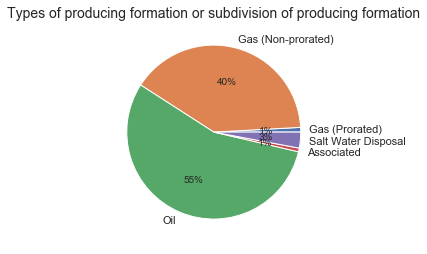

In [19]:
fig1, ax1 = plt.subplots()
labels = 'Gas (Prorated)', 'Gas (Non-prorated)', 'Oil', 'Associated', 'Salt Water Disposal'
ax1.pie(pool.groupby('pool_typ_cde').count().pool_idn, labels=labels, autopct='%0.0f%%')
ax1.set_title('Types of producing formation or subdivision of producing formation', fontdict={'fontsize': 14})

***wchistory & wellhistory***

These two table are first combined together to analyze wellbore data in New Mexico, since both of them are descriptions of wellbores. Then the combined table *wc_well_history* got extended annually according to the effective date and record termination date. 

In [20]:
# merge table wchistory and wellhistory
wc_well_history = wchistory.merge(wellhistory.drop_duplicates(subset=['api']), how='left')

In [21]:
# convert the eff_dte column to be datetime
wc_well_history.eff_dte = pd.to_datetime(wc_well_history.eff_dte)

In [22]:
# convert the rec_termn_dte column to be datetime, and assign current effective date to be 2020 to make the further analysis easier
wc_well_history.rec_termn_dte = wc_well_history.rec_termn_dte.str.replace('9999-12-31T00:00:00', '2020-12-31T00:00:00')
wc_well_history.rec_termn_dte = pd.to_datetime(wc_well_history.rec_termn_dte)

In [23]:
# expand the datetime range
wc_well_history_expand = pd.concat([pd.DataFrame({'eff_year': pd.date_range(row.eff_dte, row.rec_termn_dte, freq='A'),
                         'api': row.api, 
                         'pool_idn': row.pool_idn,
                         'wc_stat_cde': row.wc_stat_cde, 
                         'well_typ_cde': row.well_typ_cde, 
                         'prodn_meth_cde': row.prodn_meth_cde, 
                         'directional_status': row.directional_status},
                columns=['api', 'pool_idn','eff_year', 'wc_stat_cde', 'prod_prop_idn', 'well_typ_cde', 'prodn_meth_cde', 'directional_status']) 
           for i, row in wc_well_history.iterrows()], ignore_index=True)

In [24]:
# extract only the year from column eff_year
wc_well_history_expand.eff_year = wc_well_history_expand.eff_year.dt.year

In [25]:
# extract active wells from table wc_well_history_expand
wc_well_history_expand_a = wc_well_history_expand[wc_well_history_expand.wc_stat_cde == 'A']

The following plot shows that the number of active wells and permanently plugged wells are dominate in the history. The number of active wells has increased linearly from around 22k to 65k, since 1970s until the year around 2010, and the number has been stable since 2010.

Text(0.5, 1.0, 'Total number of wells varying completion status')

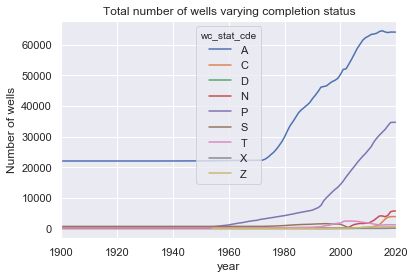

In [310]:
# plot the the number of wells changes based on different well completion status
wc_well_history_expand.groupby(['wc_stat_cde', 'eff_year']).directional_status.count().unstack(level=0).plot()
plt.ylabel('Number of wells')
plt.xlabel('year')
plt.title('Total number of wells varying completion status')

The following three pairs of plots compare the number of total wells and the number of active wells, with varying well types, well directional status, and producing methods.

The total number of gas wells and total number of oil wells are both increasing linearly since 1980s, but the increase of active oil wells has slowed down since 2000, with current number of active oil wells around 27k. The number of active gas wells has droped from around 34.3k to 33k since 2010. The number of active injection wells started to reduce in early 1990s, with current number of injection wells around 3k.

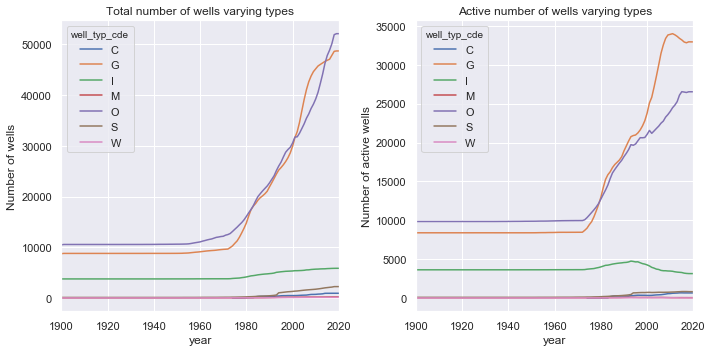

In [27]:
# plot and compare the number of wells with varying well types between entire numbers and active wells
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0] = wc_well_history_expand.groupby(['well_typ_cde', 'eff_year']).directional_status.count().unstack(level=0).plot(ax=axes[0],figsize=(10, 5))
axes[0].set_ylabel('Number of wells')
axes[0].set_xlabel('year')
axes[0].set_title('Total number of wells varying types')
plt.tight_layout()

axes[1] = wc_well_history_expand_a.groupby(['well_typ_cde', 'eff_year']).directional_status.count().unstack(level=0).plot(ax=axes[1], figsize=(10, 5))
axes[1].set_ylabel('Number of active wells')
axes[1].set_xlabel('year')
axes[1].set_title('Active number of wells varying types')
plt.tight_layout()


The vertical wells are dominate among both all kinds of wells and active wells in the history. The number of active vertical wells has grown linearly from 22k to 60k since 1970s, and it decreased about 3k since 2010, while the active horizontal and directional wells has increased from 0 to 5.5k and 1.5k since 2010.

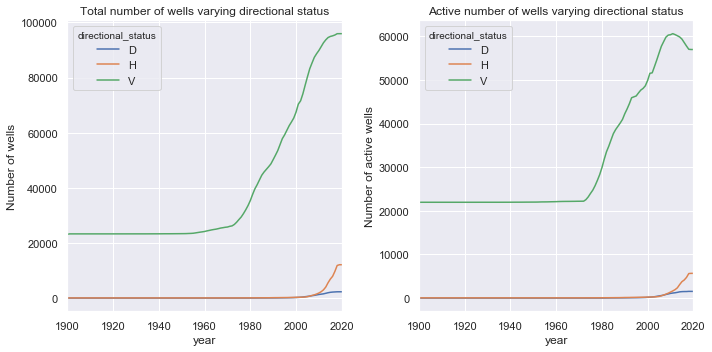

In [28]:
# plot and compare the number of wells with varying well directional status between entire numbers and active wells
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0] = wc_well_history_expand.groupby(['directional_status', 'eff_year']).directional_status.count().unstack(level=0).plot(ax=axes[0],figsize=(10, 5))
axes[0].set_ylabel('Number of wells')
axes[0].set_xlabel('year')
axes[0].set_title('Total number of wells varying directional status')
plt.tight_layout()

axes[1] = wc_well_history_expand_a.groupby(['directional_status', 'eff_year']).directional_status.count().unstack(level=0).plot(ax=axes[1], figsize=(10, 5))
axes[1].set_ylabel('Number of active wells')
axes[1].set_xlabel('year')
axes[1].set_title('Active number of wells varying directional status')
plt.tight_layout()


Flowing and pumping are two dominate producing methods, and flowing has been more popular than pumping since 1970s when they started to increase linearly. The growth of active flowing producing method started to slow down since 2008, with 36k wells currently applying flowing producing method. The active pumping (current 25k well) started to drop in 2012 when gas lift was introduced onsite.

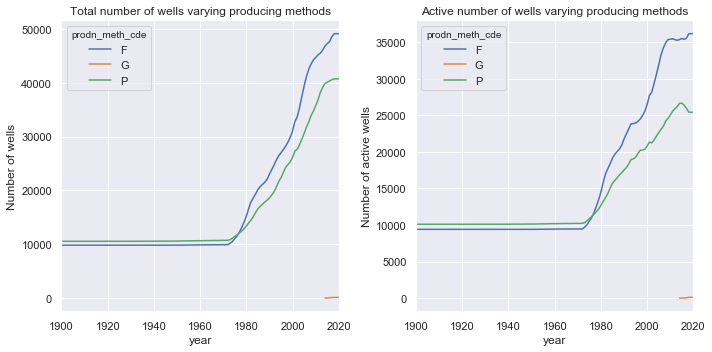

In [29]:
# plot and compare the number of wells with varying well producing methods between entire numbers and active wells
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0] = wc_well_history_expand.groupby(['prodn_meth_cde', 'eff_year']).directional_status.count().unstack(level=0).plot(ax=axes[0],figsize=(10, 5))
axes[0].set_ylabel('Number of wells')
axes[0].set_xlabel('year')
axes[0].set_title('Total number of wells varying producing methods')
plt.tight_layout()

axes[1] = wc_well_history_expand_a.groupby(['prodn_meth_cde', 'eff_year']).directional_status.count().unstack(level=0).plot(ax=axes[1], figsize=(10, 5))
axes[1].set_ylabel('Number of active wells')
axes[1].set_xlabel('year')
axes[1].set_title('Active number of wells varying producing methods')
plt.tight_layout()

***wcinjection***

First the *wcinjection* table was merged with table *pool* to extract the formation name, split the table according to the type of injected fluid: water, gas, CO2 and others, and then calculate the annual and total injection volume into each formation.

In [30]:
# match the pool names to pool identifier
wcinjection = wcinjection.merge(pool.loc[:,['pool_idn','pool_nam']], how='left')

In [327]:
# separate the wcinjection table according to the injection fluid: water, gas, co2 and others.
wcinjection_w = wcinjection[wcinjection.inj_knd_cde == 'W']
wcinjection_g = wcinjection[wcinjection.inj_knd_cde == 'G']
wcinjection_c = wcinjection[wcinjection.inj_knd_cde == 'C']
wcinjection_o = wcinjection[wcinjection.inj_knd_cde != 'W']
wcinjection_o = wcinjection_o[wcinjection_o.inj_knd_cde != 'G']
wcinjection_o = wcinjection_o[wcinjection_o.inj_knd_cde != 'C']

In [32]:
# calculate the annual and total injection volume into each formation.
wcinjection_w_pool_year = wcinjection_w.groupby(['pool_nam','prodn_yr']).inj_amt.sum()
wcinjection_w_year = wcinjection_w.groupby('prodn_yr').inj_amt.sum()
wcinjection_w_pool = wcinjection_w_pool_year.groupby(level=0).sum().sort_values(ascending=False)
wcinjection_g_pool_year = wcinjection_g.groupby(['pool_nam','prodn_yr']).inj_amt.sum()
wcinjection_g_year = wcinjection_g.groupby('prodn_yr').inj_amt.sum()
wcinjection_g_pool = wcinjection_g_pool_year.groupby(level=0).sum().sort_values(ascending=False)
wcinjection_c_pool_year = wcinjection_c.groupby(['pool_nam','prodn_yr']).inj_amt.sum()
wcinjection_c_year = wcinjection_c.groupby('prodn_yr').inj_amt.sum()
wcinjection_c_pool = wcinjection_c_pool_year.groupby(level=0).sum().sort_values(ascending=False)
wcinjection_o_pool_year = wcinjection_o.groupby(['pool_nam','prodn_yr']).inj_amt.sum()
wcinjection_o_pool = wcinjection_o_pool_year.groupby(level=0).sum().sort_values(ascending=False)

The following plots show the total water injection volume, the annual water injection volume into each formation, and the top 5 formations with the most total water injection volume. The peak of water injection happened in early 1990s, about *4.7e9* bbls/year. After the peak point, the total water injection volume increases linearly below *1.0e9* bbls/year. The top 5 formations which have the most total water injection volume are: 
+ HOBBS;GRAYBURG-SANANDRES, with total injection volume 3.42e9 bbls
+ SWD;DEVONIAN, with total injection volume 2.16e9 bbls
+ VACUUM;GRAYBURG-SANANDRES, with total injection volume 1.61e9 bbls
+ EUNICEMONUMENT;GRAYBURG-SANANDRES, with total injection volume 1.30e9 bbls
+ LANGLIEMATTIX;7RVRS-Q-GRAYBURG, with total injection volume 1.26e9 bbls

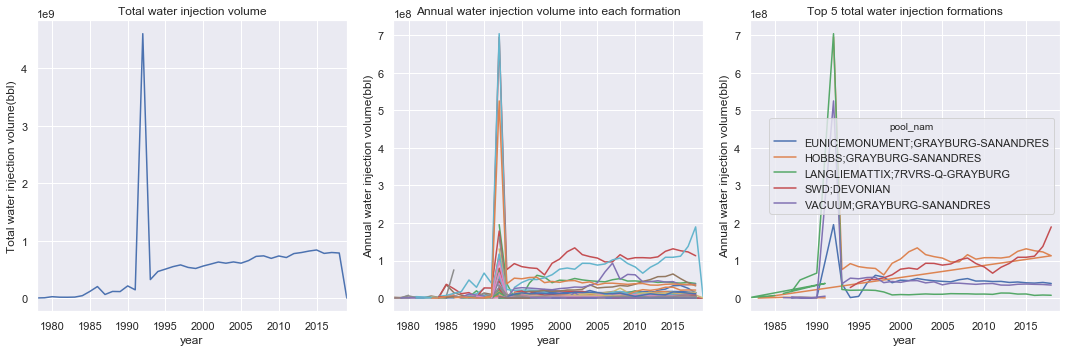

In [33]:
# plot the total and annual water injection volume into each formation, and the top 5 formations with most total injection volume
fig, axes = plt.subplots(nrows=1, ncols=3)

axes[0] = wcinjection_w_year.plot(legend=None, ax=axes[0], figsize=(15, 5))
axes[0].set_ylabel('Total water injection volume(bbl)')
axes[0].set_xlabel('year')
axes[0].set_title('Total water injection volume')
plt.tight_layout()

axes[1] = wcinjection_w_pool_year.unstack(level=0).plot(legend=None, ax=axes[1], figsize=(15, 5))
axes[1].set_ylabel('Annual water injection volume(bbl)')
axes[1].set_xlabel('year')
axes[1].set_title('Annual water injection volume into each formation')
plt.tight_layout()

axes[2] = wcinjection_w_pool_year.loc[wcinjection_w_pool[:5].index].unstack(level=0).plot(ax=axes[2], figsize=(15, 5))
axes[2].set_ylabel('Annual water injection volume(bbl)')
axes[2].set_xlabel('year')
axes[2].set_title('Top 5 total water injection formations')
plt.tight_layout()

The following plots show the total gas injection volume, the annual gas injection volume into each formaton, and the top 5 formations with the most total gas injection volume. The peak of gas injection happened in early 1990s, about *2.3e8* MCF/year. After the peak point, the total gas injection volume keeps below *1e7* MCF/year. The top 5 formations which have the most total gas injection volume are: 
+ EMPIRE;ABO, with total injection volume 2.57e8 MCF
+ PUERTOCHIQUITOMANCOS,WEST, with total injection volume 3.56e7 MCF
+ GRAMARIDGE;MORROW(GAS), with total injection volume 2.47e7 MCF
+ AGI;WOLFCAMP, with total injection volume 1.17e7 MCF
+ CAPROCK;QUEEN, with total injection volume 7.07e6 MCF

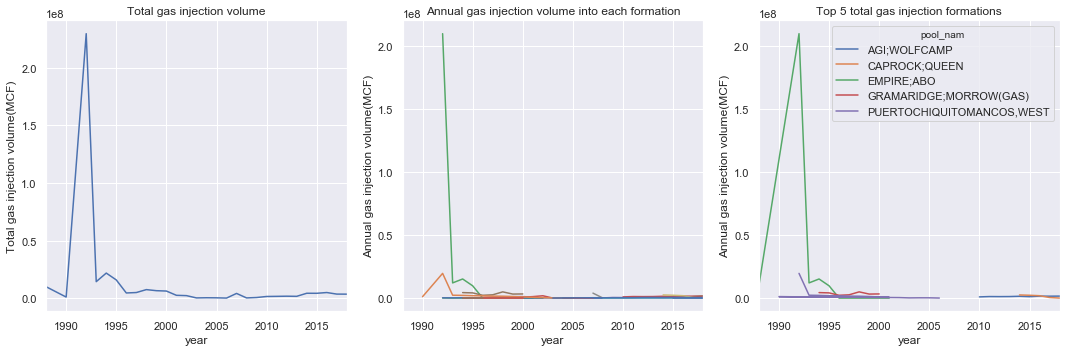

In [34]:
# plot the total and annual gas injection volume into each formation, and the top 5 formations with most total injection volume
fig, axes = plt.subplots(nrows=1, ncols=3)

axes[0] = wcinjection_g_year.plot(legend=None, ax=axes[0], figsize=(15, 5))
axes[0].set_ylabel('Total gas injection volume(MCF)')
axes[0].set_xlabel('year')
axes[0].set_title('Total gas injection volume')
plt.tight_layout()

axes[1] = wcinjection_g_pool_year.unstack(level=0).plot(legend=None,ax=axes[1], figsize=(15, 5))
axes[1].set_ylabel('Annual gas injection volume(MCF)')
axes[1].set_xlabel('year')
axes[1].set_title('Annual gas injection volume into each formation')
plt.tight_layout()

axes[2] = wcinjection_g_pool_year.loc[wcinjection_g_pool[:5].index].unstack(level=0).plot(ax=axes[2], figsize=(15, 5))
axes[2].set_ylabel('Annual gas injection volume(MCF)')
axes[2].set_xlabel('year')
axes[2].set_title('Top 5 total gas injection formations')
plt.tight_layout()


The following plots show the total CO2 injection volume, the annual CO2 injection volume into each formation, and the top 5 formations with the most total CO2 injection volume. The peak of CO2 injection happens in early 1990s, about 6.7e7 MCF/year. After the peak point, the total CO2 injection volume increases linearly with low peak at 2006, about 3.9e7 MCF/year. The top 5 formations which have the most total CO2 injection volume are:
+ VACUUM;GRAYBURG-SANANDRES, with total injection volume 7.98e8 MCF
+ HOBBS;GRAYBURG-SANANDRES, with total injection volume 7.92e8 MCF
+ MALJAMAR;GRAYBURG-SANANDRES, with total injection volume 1.62e7 MCF
+ CAPROCK;QUEEN, with total injection volume 1.30e7 MCF
+ AGI;SANANDRES, with total injection volume 5.44e6 MCF



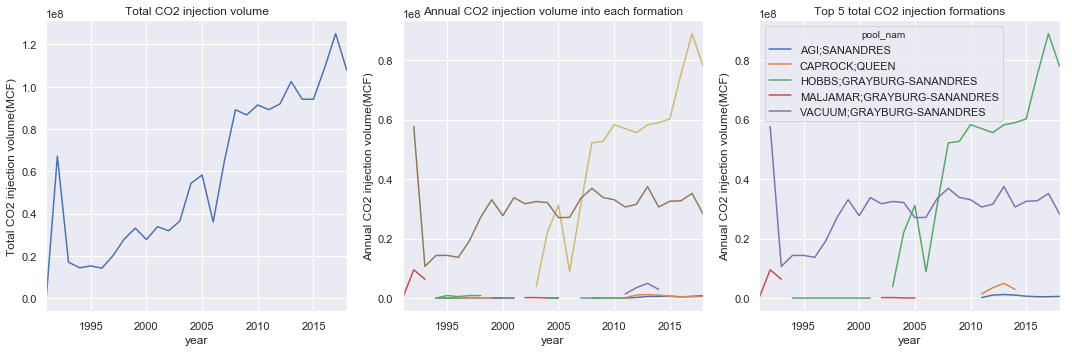

In [35]:
# plot the total and annual CO2 injection volume into each formation and the top 5 formations with most total injection volume
fig, axes = plt.subplots(nrows=1, ncols=3)

axes[0] = wcinjection_c_year.plot(legend=None, ax=axes[0], figsize=(15, 5))
axes[0].set_ylabel('Total CO2 injection volume(MCF)')
axes[0].set_xlabel('year')
axes[0].set_title('Total CO2 injection volume')
plt.tight_layout()

axes[1] = wcinjection_c_pool_year.unstack(level=0).plot(legend=None,ax=axes[1], figsize=(15, 5))
axes[1].set_ylabel('Annual CO2 injection volume(MCF)')
axes[1].set_xlabel('year')
axes[1].set_title('Annual CO2 injection volume into each formation')
plt.tight_layout()

axes[2] = wcinjection_c_pool_year.loc[wcinjection_c_pool[:5].index].unstack(level=0).plot(ax=axes[2], figsize=(15, 5))
axes[2].set_ylabel('Annual CO2 injection volume(MCF)')
axes[2].set_xlabel('year')
axes[2].set_title('Top 5 total CO2 injection formations')
plt.tight_layout()


***wcproduction***

First merge the *wcinjection* table with table *wellhistory* and *pool* to extract the well directional status information and the formation names, then split the table according to the type of produced fluid: gas, oil, water, and CO2, and then calculate the annual and total injection volume into each formation.

In [36]:
# match the well directional status
wcproduction = wcproduction.merge(wellhistory.drop_duplicates(subset=['api']), how='left')

In [37]:
# match the pool names to pool identifier
wcproduction = wcproduction.merge(pool.loc[:,['pool_idn','pool_nam']], how='left')

In [38]:
# split the table according to the types of fluid produced
wcproduction_g = wcproduction[wcproduction.prd_knd_cde == 'G']
wcproduction_o = wcproduction[wcproduction.prd_knd_cde == 'O']
wcproduction_w = wcproduction[wcproduction.prd_knd_cde == 'W']
wcproduction_c = wcproduction[wcproduction.prd_knd_cde == 'C']

In [39]:
# calculate the total and annual gas production in each formation
wcproduction_g_pool_year = wcproduction_g.groupby(['pool_nam','prodn_yr']).prod_amt.sum()
wcproduction_g_year = wcproduction_g.groupby('prodn_yr').prod_amt.sum()
wcproduction_g_pool = wcproduction_g_pool_year.groupby(level=0).sum().sort_values(ascending=False)

In [40]:
# calculate the total and annual oil production in each formation
wcproduction_o_pool_year = wcproduction_o.groupby(['pool_nam','prodn_yr']).prod_amt.sum()
wcproduction_o_year = wcproduction_o.groupby('prodn_yr').prod_amt.sum()
wcproduction_o_pool = wcproduction_o_pool_year.groupby(level=0).sum().sort_values(ascending=False)

In [41]:
# calculate the total and annual water and CO2 production in each formation
wcproduction_w_pool_year = wcproduction_w.groupby(['pool_nam','prodn_yr']).prod_amt.sum()
wcproduction_w_year = wcproduction_w.groupby('prodn_yr').prod_amt.sum()
wcproduction_w_pool = wcproduction_w_pool_year.groupby(level=0).sum().sort_values(ascending=False)
wcproduction_c_pool_year = wcproduction_c.groupby(['pool_nam','prodn_yr']).prod_amt.sum()
wcproduction_c_year = wcproduction_c.groupby('prodn_yr').prod_amt.sum()
wcproduction_c_pool = wcproduction_c_pool_year.groupby(level=0).sum().sort_values(ascending=False)

The following plots show the annual total gas production in New Mexico state, and the annual gas production in each formation, and the top 5 formations which have the most total gas production. The annual gas production reaches peak in early 1990s, around 3e10 MCF/year, and then keeps stable between 2e9 MCF/year and 3e9 MCF/year. The individual formation follows the pattern, and the top 5 gas production formations are :
+ BLANCO-MESAVERDE(PRORATEDGAS), with total production volume 1.39e10 MCF
+ BASINFRUITLANDCOAL(GAS), with total production volume 1.23e10 MCF
+ BASINDAKOTA(PRORATEDGAS), with total production volume 7.39e9 MCF
+ BRAVODOMECARBONDIOXIDEGAS640, with total production volume 2.69e9 MCF
+ EUMONT;YATES-7RVRS-QUEEN(GAS), with total production volume 1.75e9 MCF

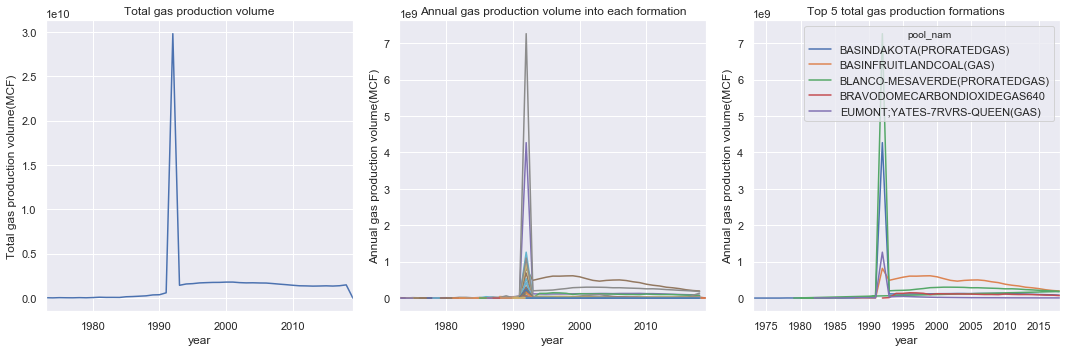

In [42]:
# plot the total and annual gas production volume into each formation and the top 5 formations with most total injection volume
fig, axes = plt.subplots(nrows=1, ncols=3)

axes[0] = wcproduction_g_year.plot(legend=None, ax=axes[0], figsize=(15, 5))
axes[0].set_ylabel('Total gas production volume(MCF)')
axes[0].set_xlabel('year')
axes[0].set_title('Total gas production volume')
plt.tight_layout()

axes[1] = wcproduction_g_pool_year.unstack(level=0).plot(legend=None,ax=axes[1], figsize=(15, 5))
axes[1].set_ylabel('Annual gas production volume(MCF)')
axes[1].set_xlabel('year')
axes[1].set_title('Annual gas production volume into each formation')
plt.tight_layout()

axes[2] = wcproduction_g_pool_year.loc[wcproduction_g_pool[:5].index].unstack(level=0).plot(ax=axes[2], figsize=(15, 5))
axes[2].set_ylabel('Annual gas production volume(MCF)')
axes[2].set_xlabel('year')
axes[2].set_title('Top 5 total gas production formations')
plt.tight_layout()

The following plots show the annual total oil production, and the annual oil production in each formation, and the top 5 formations with the most total oil production. The annual total oil production reaches peak in early 1990s, around 2.8e9 bbls/year, and then keeps stable around 1e9 bbls/year until 2010, and the total annual production has increased to about 2e9 bbls/year since 2010. The individual formation follows this pattern that the production reaches peak in early 1990s. The top 5 formations which produce the most oil are:
+ VACUUM;GRAYBURG-SANANDRES, with total production volume 3.97e8 bbls
+ HOBBS;GRAYBURG-SANANDRES, with total production volume 3.89e8 bbls
+ EUNICEMONUMENT;GRAYBURG-SANANDRES, with total production volume 3.70e8 bbls
+ EMPIRE;ABO, with total production volume 2.15e8 bbls
+ MALJAMAR;GRAYBURG-SANANDRES, with total production volume 1.55e8 bbls


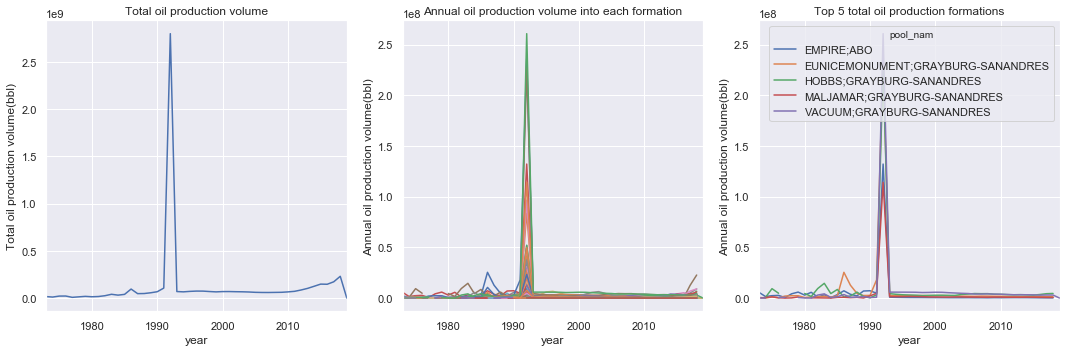

In [43]:
# plot the total and annual oil production volume into each formation and the top 5 formations with most total injection volume
fig, axes = plt.subplots(nrows=1, ncols=3)

axes[0] = wcproduction_o_year.plot(legend=None, ax=axes[0], figsize=(15, 5))
axes[0].set_ylabel('Total oil production volume(bbl)')
axes[0].set_xlabel('year')
axes[0].set_title('Total oil production volume')
plt.tight_layout()

axes[1] = wcproduction_o_pool_year.unstack(level=0).plot(legend=None,ax=axes[1], figsize=(15, 5))
axes[1].set_ylabel('Annual oil production volume(bbl)')
axes[1].set_xlabel('year')
axes[1].set_title('Annual oil production volume into each formation')
plt.tight_layout()

axes[2] = wcproduction_o_pool_year.loc[wcproduction_o_pool[:5].index].unstack(level=0).plot(ax=axes[2], figsize=(15, 5))
axes[2].set_ylabel('Annual oil production volume(bbl)')
axes[2].set_xlabel('year')
axes[2].set_title('Top 5 total oil production formations')
plt.tight_layout()

The following plots show the annual total water production, and the annual water production in each formation, and the top 5 formations with the most total water production. The peak annual total water production happens in early 1990s, around 5.7e9 bbls/year, after that the water production volume increases linearly from 4e8 bbls/year to 1e9 bbls/year. The individual formation follows similar pattern. The top 5 formations which produce the most water are:
+ HOBBS;GRAYBURG-SANANDRES, with total production volume 3.78e9 bbls
+ VACUUM;GRAYBURG-SANANDRES, with total production volume 1.47e9 bbls
+ EUNICEMONUMENT;GRAYBURG-SANANDRES, with total production volume 1.43e9 bbls
+ INDIANBASIN;UPPERPENN(ASSOC), with total production volume 8.19e8 bbls
+ JALMAT;TAN-YATES-7RVRS(OIL), with total production volume 8.13e8 bbls

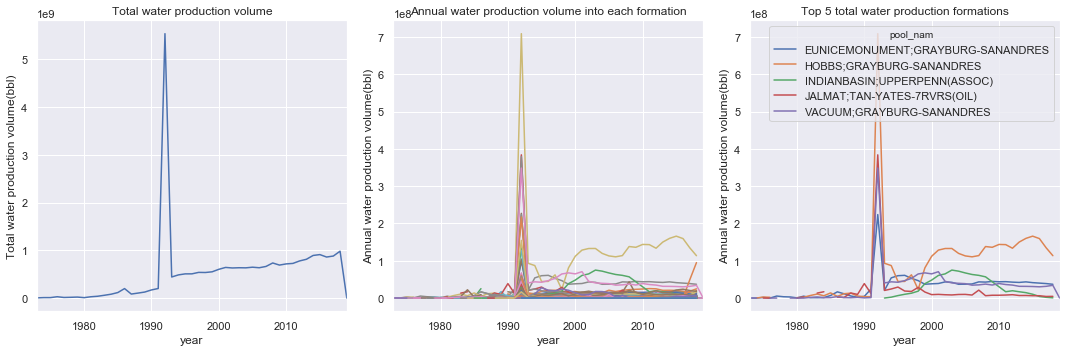

In [44]:
# plot the total and annual water production volume into each formation and the top 5 formations with most total injection volume
fig, axes = plt.subplots(nrows=1, ncols=3)

axes[0] = wcproduction_w_year.plot(legend=None, ax=axes[0], figsize=(15, 5))
axes[0].set_ylabel('Total water production volume(bbl)')
axes[0].set_xlabel('year')
axes[0].set_title('Total water production volume')
plt.tight_layout()

axes[1] = wcproduction_w_pool_year.unstack(level=0).plot(legend=None,ax=axes[1], figsize=(15, 5))
axes[1].set_ylabel('Annual water production volume(bbl)')
axes[1].set_xlabel('year')
axes[1].set_title('Annual water production volume into each formation')
plt.tight_layout()

axes[2] = wcproduction_w_pool_year.loc[wcproduction_w_pool[:5].index].unstack(level=0).plot(ax=axes[2], figsize=(15, 5))
axes[2].set_ylabel('Annual water production volume(bbl)')
axes[2].set_xlabel('year')
axes[2].set_title('Top 5 total water production formations')
plt.tight_layout()

The following plots show the annual total CO2 production in New Mexico state, and the annual CO2 production in each formation, and the top 3 formations which have the most total CO2 production. The annual CO2 production reaches peak in 1992, around 9.5e8 MCF/year. There are three formaitons produced CO2 from late 1980s to early 1990s, and the total CO2 production from each formation is:
+ BRAVODOMECARBONDIOXIDEGAS640, with total production volume 1.06e10 MCF
+ WESTBRAVODOMECO2GAS, with total production volume 7.37e6 MCF
+ NORTHEASTCOUNTIESUNDES,CO2, with total production volume 5.30e5 MCF

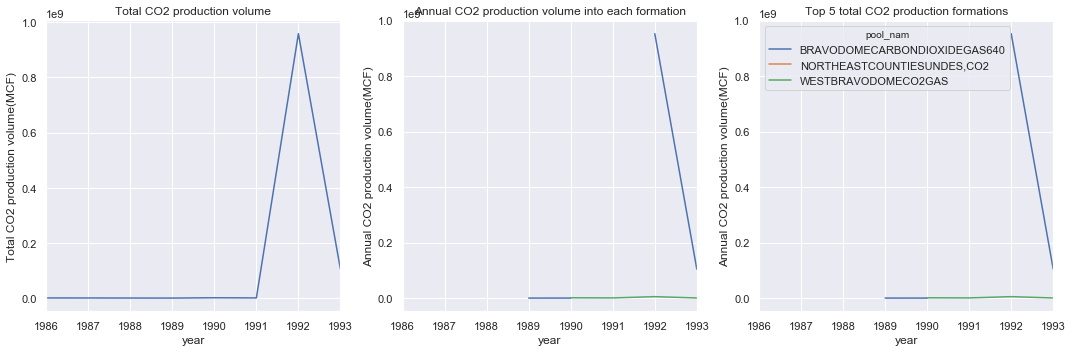

In [45]:
# plot the total and annual CO2 production volume into each formation and the top 5 formations with most total injection volume
fig, axes = plt.subplots(nrows=1, ncols=3)

axes[0] = wcproduction_c_year.plot(legend=None, ax=axes[0], figsize=(15, 5))
axes[0].set_ylabel('Total CO2 production volume(MCF)')
axes[0].set_xlabel('year')
axes[0].set_title('Total CO2 production volume')
plt.tight_layout()

axes[1] = wcproduction_c_pool_year.unstack(level=0).plot(legend=None,ax=axes[1], figsize=(15, 5))
axes[1].set_ylabel('Annual CO2 production volume(MCF)')
axes[1].set_xlabel('year')
axes[1].set_title('Annual CO2 production volume into each formation')
plt.tight_layout()

axes[2] = wcproduction_c_pool_year.loc[wcproduction_c_pool[:5].index].unstack(level=0).plot(ax=axes[2], figsize=(15, 5))
axes[2].set_ylabel('Annual CO2 production volume(MCF)')
axes[2].set_xlabel('year')
axes[2].set_title('Top 5 total CO2 production formations')
plt.tight_layout()

The following plots indicate annual total gas, oil and water production volume from vertical, horizontal, and directional wells. It shows that the vertical wells dominate the production in the history until 2010s when horizontal wells started to apply in oil and gas fields. The gas production from horizontal wells is very close to the production from vertical wells in 2018, with the tendency to exceed in coming year. The oil production from horizontal wells has exceeded the production from vertical well in 2013, and the production volume from horizontal wells is about four times of the production from vertical wells. At the same time, water production from horizontal wells increases and exceeds the production from vertical wells in 2017.

In [46]:
wcproduction_g_direction = wcproduction_g.groupby(['directional_status','prodn_yr']).prod_amt.sum()

In [47]:
wcproduction_o_direction = wcproduction_o.groupby(['directional_status','prodn_yr']).prod_amt.sum()

In [48]:
wcproduction_w_direction = wcproduction_w.groupby(['directional_status','prodn_yr']).prod_amt.sum()

C:\Users\Jing\Anaconda3\envs\ipykernel_py3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users\Jing\Anaconda3\envs\ipykernel_py3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users\Jing\Anaconda3\envs\ipykernel_py3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


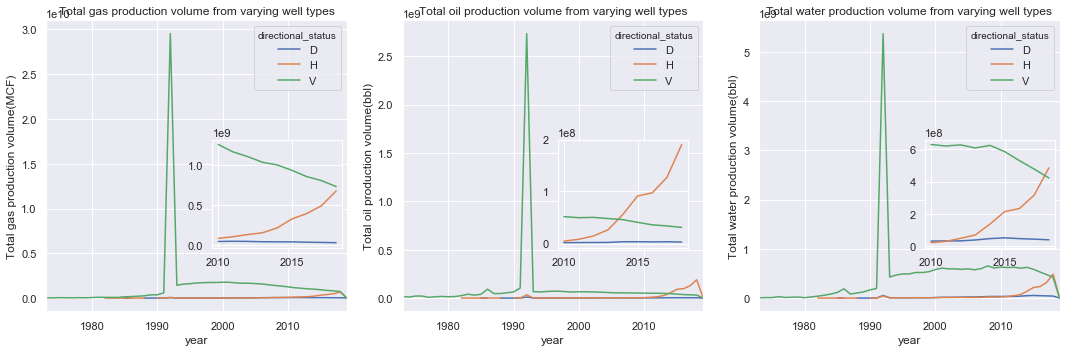

In [53]:
# plot the annual total gas, oil, and water production volume from vertical, horizontal and directional wells
fig, axes = plt.subplots(nrows=1, ncols=3)

axes[0] = wcproduction_g_direction.unstack(level=0).plot(ax=axes[0], figsize=(15, 5))
axes[0].set_ylabel('Total gas production volume(MCF)')
axes[0].set_xlabel('year')
axes[0].set_title('Total gas production volume from varying well types')
sub_axes = plt.axes([.2, .3, .12, .3]) 
sub_axes.plot(wcproduction_g_direction.unstack(level=0).loc[2010:2018,:])
plt.tight_layout()

axes[1] = wcproduction_o_direction.unstack(level=0).plot(ax=axes[1], figsize=(15, 5))
axes[1].set_ylabel('Total oil production volume(bbl)')
axes[1].set_xlabel('year')
axes[1].set_title('Total oil production volume from varying well types')
sub_axes = plt.axes([.52, .3, .12, .3]) 
sub_axes.plot(wcproduction_o_direction.unstack(level=0).loc[2010:2018,:])
plt.tight_layout()

axes[2] = wcproduction_w_direction.unstack(level=0).plot(ax=axes[2], figsize=(15, 5))
axes[2].set_ylabel('Total water production volume(bbl)')
axes[2].set_xlabel('year')
axes[2].set_title('Total water production volume from varying well types')
sub_axes = plt.axes([.86, .3, .12, .3]) 
sub_axes.plot(wcproduction_w_direction.unstack(level=0).loc[2010:2018,:])
plt.tight_layout()

**[Convert the production gas to barrel of oil equivalent (BOE)](https://en.wikipedia.org/wiki/Barrel_of_oil_equivalent)**, and analyze the relationship between production and injection.

The barrel of oil equivalent (BOE) is a unit of energy based on the approximate energy released by burning one barrel (42 U.S. gallons or 158.9873 litres) of crude oil. The USGS gives a figure of 6,000 cubic feet (170 cubic meters) of typical natural gas are equivalent to one BOE.

In [82]:
# Convert the gas production to BOE
wcproduction_g.loc[:,['prod_amt_boe']] = wcproduction_g['prod_amt'] / 6000

In [328]:
# Sum the oil and gas production of each well
wcproduction_o_well = wcproduction_o.groupby('api')['prod_amt'].sum()
wcproduction_g_well = wcproduction_g.groupby('api')['prod_amt_boe'].sum()
wcproduction_w_well = wcproduction_w.groupby('api')['prod_amt'].sum()

In [329]:
# Sum the oil and gas volume to get the total productin
wcproduction_o_g_well = wcproduction_o_well.append(wcproduction_g_well).groupby('api').sum()
# Convert series to dataframe
wcproduction_o_g_well = wcproduction_o_g_well.to_frame().reset_index()
wcproduction_o_g_well = wcproduction_o_g_well.rename(columns= {0: 'prod_total'})
wcproduction_w_well = wcproduction_w_well.to_frame().reset_index()
wcproduction_w_well = wcproduction_w_well.rename(columns= {'prod_amt': 'prod_total'})
# match the well directional status
wcproduction_o_g_well = wcproduction_o_g_well.merge(wellhistory.drop_duplicates(subset=['api']), how='left')
wcproduction_w_well = wcproduction_w_well.merge(wellhistory.drop_duplicates(subset=['api']), how='left')

In [341]:
wcproduction_well_direct

,directional_status,prod_total,production
0,D,5.640800e+07,Oil&Gas
1,H,6.846060e+08,Oil&Gas
2,V,4.862341e+09,Oil&Gas
0,D,6.871883e+08,Water
1,H,1.797267e+09,Water
2,V,2.122637e+10,Water


The following logarithmic scale plot shows the total oil/gas production after converting vs. total water production from directional, horizontal, and vertical wells respectively. Vertical wells lead both oil/gas (5e3 MMBL) and water (2e4 MMBL) production; total 7e2 MMBL oil and gas, and 1.8e3 MMBL are produced from horizontal wells; total 56 MMBL oil and gas, and 7e2 MMBL water are produced from directional wells.

Text(0, 0.5, 'Total O&G and Water production (MMBL)')

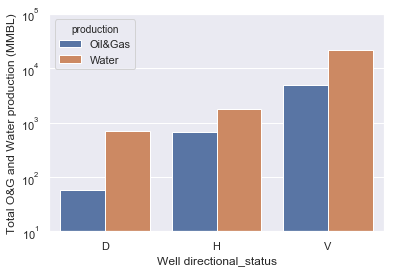

In [340]:
# Convert series to dataframe
wcproduction_o_g_well_direct = wcproduction_o_g_well.groupby('directional_status')['prod_total'].sum().to_frame().reset_index()
wcproduction_w_well_direct = wcproduction_w_well.groupby('directional_status')['prod_total'].sum().to_frame().reset_index()
wcproduction_o_g_well_direct['production'] = 'Oil&Gas'
wcproduction_w_well_direct['production'] = 'Water'
wcproduction_well_direct = wcproduction_o_g_well_direct.append(wcproduction_w_well_direct)
# Plot bar plot of total production of each well directional status
sns.barplot(x='directional_status', y=wcproduction_well_direct['prod_total']/(1e6),hue='production',data= wcproduction_well_direct)
plt.yscale('log')
plt.ylim([10,1e5])
plt.xlabel('Well directional_status')
plt.ylabel('Total O&G and Water production (MMBL)')

In [148]:
# Sum the oil and gas production of each formation
wcproduction_o_pool = wcproduction_o.groupby('pool_nam')['prod_amt'].sum()
wcproduction_g_pool = wcproduction_g.groupby('pool_nam')['prod_amt_boe'].sum()

In [307]:
# Sum the oil and gas volume to get the total productin
wcproduction_o_g_pool = wcproduction_o_pool.append(wcproduction_g_pool).groupby('pool_nam').sum().sort_values(ascending=False)
# Convert series to dataframe
wcproduction_o_g_pool = wcproduction_o_g_pool.to_frame().reset_index()
wcproduction_o_g_pool = wcproduction_o_g_pool.rename(columns= {0: 'prod_total'})

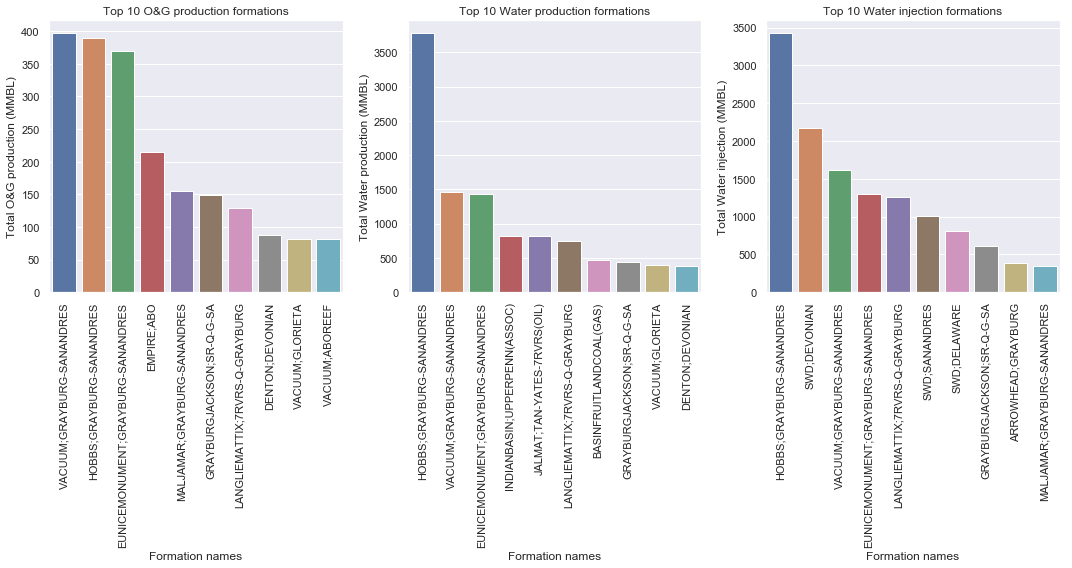

In [306]:
# plot and regress the relationship between total gas and oil production, water production, and water injection in various formations
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15, 8))

axes[0] = sns.barplot(wcproduction_o_g_pool['pool_nam'][:10], wcproduction_o_g_pool['prod_total'][:10]/(1e6),ax=axes[0])
axes[0].set_xlabel('Formation names')
axes[0].set_ylabel('Total O&G production (MMBL)')
axes[0].set_title('Top 10 O&G production formations')
plt.setp(axes[0].get_xticklabels(), rotation=90)

# Convert series to dataframe
wcproduction_w_pool = wcproduction_w_pool.to_frame().reset_index()
axes[1] = sns.barplot(wcproduction_w_pool['pool_nam'][:10], wcproduction_w_pool['prod_amt'][:10]/(1e6),ax=axes[1])
axes[1].set_xlabel('Formation names')
axes[1].set_ylabel('Total Water production (MMBL)')
axes[1].set_title('Top 10 Water production formations')
plt.setp(axes[1].get_xticklabels(), rotation=90)

# Convert series to dataframe
wcinjection_w_pool = wcinjection_w_pool.to_frame().reset_index()
axes[2] = sns.barplot(wcinjection_w_pool['pool_nam'][:10], wcinjection_w_pool['inj_amt'][:10]/(1e6), ax=axes[2])
axes[2].set_xlabel('Formation names')
axes[2].set_ylabel('Total Water injection (MMBL)')
axes[2].set_title('Top 10 Water injection formations')
plt.setp(axes[2].get_xticklabels(), rotation=90)
plt.tight_layout()

The above plots show the top 10 oil and gas production formations, top 10 water production formations, and top 10 water injection formation. There is a high correlation between production and injection generally, meaning more injection and more production, for example the No.1 water injection formation *HOBBS;GRAYBURG-SANANDRES* produces the No.1 water and No.2 oil and gas. 

In reality, we prefer high oil and gas production and low water production with either high or low water injection, and trying to avoid the opposite. The No.2 water injection formation *SWD;DEVONIAN* doesn't production corresponding oil and gas, which is out of top 10 oil and gas production formations; and the formation is out of top 10 water production either, thus it's interesting to further study on the real formations which water injection into. The No.4 oil and gas production formation *EMPIRE;ABO* is out of the top 10 water production and injection, which is a signal of high water flooding efficiency. 

The following three plots indicate positive linear relationships between water production and oil/gas production, water injection and oil/gas production, and water injection and water production from various formations. 

In [287]:
wcinjection_production_pool = wcinjection_w_pool.merge(wcproduction_w_pool, how='outer').merge(wcproduction_o_g_pool,how='outer')
wcinjection_production_pool = wcinjection_production_pool.rename(columns= {'inj_amt': 'inj_w', 'prod_amt':'prod_w','prod_total':'prod_o_g'})
wcinjection_production_pool = wcinjection_production_pool.fillna(0)

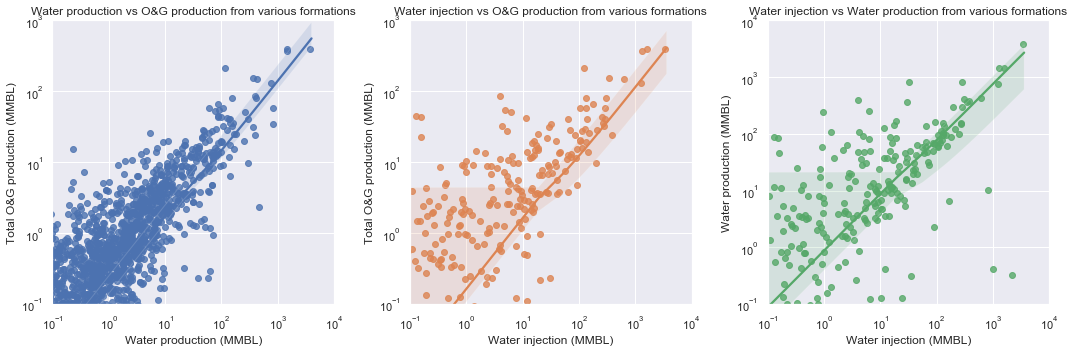

In [343]:
# plot and regress the relationship between total gas and oil production, water production, and water injection in various formations
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15, 5))

axes[0] = sns.regplot(wcinjection_production_pool['prod_w']/1e6,wcinjection_production_pool['prod_o_g']/1e6,ax=axes[0])
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlim([0.1,10000])
axes[0].set_ylim([0.1,1000])
axes[0].set_xlabel('Water production (MMBL)')
axes[0].set_ylabel('Total O&G production (MMBL)')
axes[0].set_title('Water production vs O&G production from various formations')
plt.tight_layout()

axes[1] = sns.regplot(wcinjection_production_pool['inj_w']/1e6,wcinjection_production_pool['prod_o_g']/1e6,ax=axes[1])
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlim([0.1,10000])
axes[1].set_ylim([0.1,1000])
axes[1].set_xlabel('Water injection (MMBL)')
axes[1].set_ylabel('Total O&G production (MMBL)')
axes[1].set_title('Water injection vs O&G production from various formations')
plt.tight_layout()

axes[2] = sns.regplot(wcinjection_production_pool['inj_w']/1e6,wcinjection_production_pool['prod_w']/1e6, ax=axes[2])
axes[2].set_xscale('log')
axes[2].set_yscale('log')
axes[2].set_xlim([0.1,10000])
axes[2].set_ylim([0.1,10000])
axes[2].set_xlabel('Water injection (MMBL)')
axes[2].set_ylabel('Water production (MMBL)')
axes[2].set_title('Water injection vs Water production from various formations')
plt.tight_layout()

## Conclusion

+ Among the total *4978* formations (pools), *43(1%)* formations are gas(prorated), *1993(40%)* are gas (non-prorated), 2761(56%)* are oil fromations, *34(1%)* are associated formations, and *147(3%)* are salt water disposal formations.
+ The number of active wells has increased linearly from around 22k to 65k, since 1970s until the year around 2010, and the number has been stable since 2010.
+ The total number of gas wells and total number of oil wells are both increasing linearly since 1980s, but the increase of active oil wells has slowed down since 2000, with current number of active oil wells around 27k. The number of active gas wells has droped from around 34.3k to 33k since 2010. The number of active injection wells started to reduce in early 1990s, with current number of injection wells around 3k.
+ The vertical wells are dominate among both all kinds of wells and active wells in the history. The number of active vertical wells has grown linearly from 22k to 60k since 1970s, and it decreased about 3k since 2010, while the active horizontal and directional wells has increased from 0 to 5.5k and 1.5k since 2010.
+ Flowing and pumping are two dominate producing methods, and flowing has been more popular than puming since 1970s when they started to increase linearly. The growth of active flowing producing method started to slow down since 2008, with 36k wells currently applying flowing producing method. The active pumping (current 25k well) started to drop in 2012 when gas lift was introduced onsite.
+ Both the injection (water, gas, CO2) and production (gas, oil, water, and CO2) reach peak in 1992:
    - The peak water injection is about *4.7e9* bbls/year. After the peak point, the total water injection volume increases linearly below *1.0e9* bbls/year. 
    - The peak gas injection is about *2.3e8* MCF/year. After the peak point, the total gas injection volume keeps constant below *1e7* MCF/year.
    - The peak CO2 injection is about 6.7e7 MCF/year. After the peak point, the total CO2 injection volume increases linearly with a low peak at 2006, about 3.9e7 MCF/year. 
    - The peak annual gas production is around 3e10 MCF/year, and then the production keeps stable between 2e9 MCF/year and 3e9 MCF/year. 
    - The peak annual oil production is around 2.8e9 bbls/year, and then the production keeps stable around 1e9 bbls/year until 2010, and the total annual production has increased to about 2e9 bbls/year since 2010. 
    - The peak annual total water production is around 5.7e9 bbls/year, after that the water production volume increases linearly from 4e8 bbls/year to 1e9 bbls/year. 
    - There are three formaitons produced CO2 from late 1980s to early 1990s, and peak annual CO2 production is around 9.5e8 MCF/year.        
+ The vertical wells dominate the production in the history until 2010s when horizontal wells started to apply in oil and gas fields. The gas production from horizontal wells is very close to the production from vertical wells in 2018, with the tendency to exceed in coming year. The oil production from horizontal wells has exceeded the production from vertical well in 2013, and the production volume from horizontal wells is about four times of the production from vertical wells. At the same time, water production from horizontal wells increases and exceeds the production from vertical wells in 2017.
+ Converting gas to barrel of oil equivalent, the vertical wells lead both total oil/gas (5e3 MMBL) and total water (2e4 MMBL) production; total 7e2 MMBL oil and gas, and 1.8e3 MMBL are produced from horizontal wells; total 56 MMBL oil and gas, and 7e2 MMBL water are produced from directional wells.
+ There is a positive linear relationships between water production and oil/gas production, water injection and oil/gas production, and water injection and water production from various formations. In reality, we prefer high oil and gas production and low water production with either high or low water injection, and trying to avoid the opposite. The No.2 water injection formation *SWD;DEVONIAN* doesn't production corresponding oil and gas, which is out of top 10 oil and gas production formations; and the formation is out of top 10 water production either, thus it's interesting to further study on the real formations which water injection into. The No.4 oil and gas production formation *EMPIRE;ABO* is out of the top 10 water production and injection, which is a signal of high water flooding efficiency. 
+ The efficiency of water flooding is good in some formations which have high oil and gas production, such as
    - HOBBS;GRAYBURG-SANANDRES, 
    - VACUUM;GRAYBURG-SANANDRES, 
    - EUNICEMONUMENT;GRAYBURG-SANANDRES, 
    - EMPIRE;ABO, 
    - MALJAMAR;GRAYBURG-SANANDRES      

## Future Work:

1. The influence of production methods on production;
2. Further water, gas and CO2 flooding efficiency study on certain formations;
3. As the horizontal well starts to dominate production in the past 5 years, it's interesting to further study on horizontal well completion methods, such as hydraulic fracturing.